# ML vs non-ML Pylint Exploration

Dependencies:
- analyse_py_ver notebook (best_guess.csv)

This notebook:

- Marks repos as ML/non-ML based on fraction of ML modules.
- Merges various sources into a single dataframe
- Normalises the number of Pylint Errors based on the number of SLOC (Source Linces of Code)
- Visualises the results for each type of Pylint Error/Warning, broken down by ML/non-ML
- Visualises the results for each type of Pylint Error/Warning, broken down by category (ML0, ML1, ML2, ML3, ML4)
- Ranks Pylint Errors/Warnings by the significance of the difference between messages for ML/non-ML repos

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import scipy.stats as stats
import altair as alt # Python wrapper for Vega-Lite visualisation grammarimport altair as alt
from altair import datum

In [2]:
DATA_DIR = "../output/"

In [3]:
# https://altair-viz.github.io/user_guide/faq.html#altair-faq-large-notebook
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Label Repo Type

In [4]:
proj_labels = pd.read_csv("proj_labels.csv")
#https://stackoverflow.com/questions/12860421/python-pandas-pivot-table-with-aggfunc-count-unique-distinct
proj_labels_pivot = pd.pivot_table(proj_labels, values="path", index="repo", columns="cat", aggfunc=pd.Series.nunique)
proj_labels_pivot = proj_labels_pivot.fillna(0)

In [5]:
proj_labels_pivot

cat         ml0  ml1  ml2  ml3  ml4  other  test
repo                                            
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0
...         ...  ...  ...  ...  ...    ...   ...
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0

[222 rows x 7 columns]

In [6]:
proj_labels_pivot["total"] = proj_labels_pivot.apply("sum", axis=1)
proj_labels_pivot["frac_ml"] = proj_labels_pivot["ml0"] / proj_labels_pivot["total"]

In [7]:
proj_labels_pivot.sort_values("frac_ml", ascending=False)

cat        ml0  ml1  ml2  ml3  ml4  other  test  total  frac_ml
repo                                                           
53430164   4.0  0.0  0.0  0.0  0.0    0.0   0.0    4.0      1.0
69533102   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
21574434   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
67244718   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
109562178  3.0  0.0  0.0  0.0  0.0    0.0   0.0    3.0      1.0
...        ...  ...  ...  ...  ...    ...   ...    ...      ...
17856536   0.0  0.0  0.0  0.0  0.0  498.0  24.0  522.0      0.0
18617947   0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0      0.0
18633922   0.0  0.0  0.0  0.0  0.0    3.0   0.0    3.0      0.0
41890193   0.0  0.0  0.0  0.0  0.0   20.0   0.0   20.0      0.0
41590      0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0      0.0

[222 rows x 9 columns]

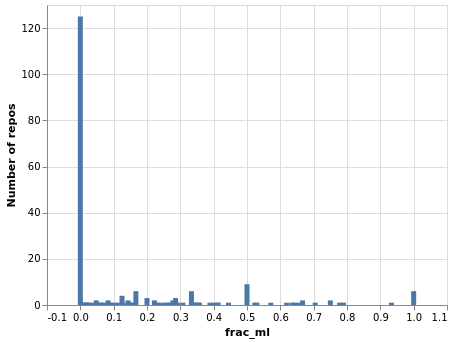

In [8]:
chart = alt.Chart(proj_labels_pivot).mark_bar().encode(
    x = alt.X('frac_ml', type='quantitative', title="frac_ml", scale=alt.Scale(domain=(0,1))),
    y = alt.Y('count()', title="Number of repos"),
)
chart

In [9]:
chart.save("proj_labels_pivot.png")

We declare any repos with at least 10% of modules containing an import of an ML library as being ML. E.g. if there are 20 modules, and at least two import an ML library such as Tensorflow, the repo will be marked as ML.

This threshold helps ensure that the project is genuinely ML code, rather than just a large repo that happens to contain a few ML examples.

In [10]:
proj_labels_pivot["is_ml_repo"] = proj_labels_pivot["frac_ml"] >= 0.1

In [11]:
proj_labels_pivot

cat         ml0  ml1  ml2  ml3  ml4  other  test  total   frac_ml  is_ml_repo
repo                                                                         
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0  0.000000       False
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0   45.0  0.355556        True
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0   13.0  0.000000       False
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0  632.0  0.000000       False
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0  0.000000       False
...         ...  ...  ...  ...  ...    ...   ...    ...       ...         ...
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0   44.0  0.704545        True
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0   42.0  0.619048        True
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0   74.0  0.635135        True
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0   18.0  0.777778        True
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0   72.0  0.291667        True

[222 rows x 10 columns]

## Python Version

We extract a list of Python2 repos, and a list of Python3 repos

In [12]:
best_guess_df = pd.read_csv("best_guess.csv")

In [13]:
py2_repos = best_guess_df[best_guess_df["bestguess"] == "py2"]["repo"].unique()

In [14]:
py2_repos

array([    41590,    118130,    550482,    590142,    607040,    759484,
          791699,    838999,   1383879,   1465795,   1730849,   2000318,
         2240410,   2660382,   2926406,   3129447,   3277926,   3287642,
         3546355,   3932246,   4035165,   4066562,   6125281,   6291757,
         6465727,   6532318,   6859723,   6972160,   8189818,   8194692,
         8373425,   8408538,   8776176,   8832136,   9530414,   9651619,
         9996540,  10224745,  10404901,  11075275,  11414686,  11469390,
        12086903,  12161605,  12275225,  12494124,  13210816,  13570500,
        13884324,  13970869,  14161890,  14284950,  15112920,  15120191,
        15221621,  15674392,  15899135,  15985050,  16227240,  16742762,
        17639957,  17856536,  18617947,  18633922,  18960265,  19160523,
        19346982,  19703420,  20021753,  20030361,  20090068,  21037072,
        21574434,  23103659,  23129008,  23409750,  23579369,  26118292,
        26595015,  27339738,  27731143,  27888002, 

In [15]:
py3_repos = best_guess_df[best_guess_df["bestguess"] == "py3"]["repo"].unique()

In [16]:
py3_repos

array([  3255194,   5651850,   8424376,  13261025,  15247930,  18766036,
        19057465,  21438190,  21467110,  22354028,  23770267,  24100479,
        25234558,  26073196,  27677040,  30111238,  34639031,  35187829,
        36151086,  38108816,  38463323,  40087278,  41890193,  42242637,
        44304626,  44606420,  46801369,  46939261,  46973796,  48450890,
        52581991,  53430164,  53941799,  56555556,  57212617,  60109178,
        61813823,  62956639,  63867447,  67244718,  69533102,  70118622,
        70148832,  72225778,  74471781,  76041801,  76262719,  77101262,
        77662713,  78097444,  78508757,  79748320,  80504468,  81585787,
        83399665,  89879629,  89886473,  91313284,  91356408,  91599679,
        92235513,  92270845,  92591596,  93305304,  96111593,  97074218,
        97207348,  97508182,  99785600, 100073601, 101607701, 103471501,
       108704309, 109562178, 111079817, 111696541, 112664267, 114098658,
       118248283, 119537109])

In [17]:
# Should have nothing in common
set(py2_repos) & set(py3_repos)

set()

In [18]:
len(py2_repos) + len(py3_repos)

222

## Merge Python2 and Python3 Pylint results

We select Pylint results based on the best guess of the Python version

In [19]:
lint_df_py2 = pd.read_csv(join(DATA_DIR, "results_pylint_python2.csv"))
lint_df_py3 = pd.read_csv(join(DATA_DIR, "results_pylint_python3.csv"))
lint_df_py2_sel = lint_df_py2[lint_df_py2["repo"].isin(py2_repos)]
lint_df_py3_sel = lint_df_py3[lint_df_py3["repo"].isin(py3_repos)]
lint_df_combo = pd.concat([lint_df_py2_sel, lint_df_py3_sel])

In [20]:
lint_df_combo.repo.nunique()

222

In [21]:
lint_df_combo

repo                              path        type  \
1530    56709482  56709482/csv_monkey_converter.py  convention   
1531    56709482  56709482/csv_monkey_converter.py       error   
1532    56709482  56709482/csv_monkey_converter.py  convention   
1533    56709482  56709482/csv_monkey_converter.py  convention   
1534    56709482  56709482/csv_monkey_converter.py  convention   
...          ...                               ...         ...   
587912  62956639       62956639/models/char_tcn.py  convention   
587913  62956639       62956639/models/char_tcn.py  convention   
587914  62956639       62956639/models/char_tcn.py  convention   
587915  62956639       62956639/models/char_tcn.py  convention   
587916  62956639       62956639/models/char_tcn.py    refactor   

                      module                   obj  line  column  \
1530    csv_monkey_converter                   NaN   1.0     0.0   
1531    csv_monkey_converter                   NaN   1.0     0.0   
1532    csv_monkey_converter                   NaN   5.0     0.0   
1533    csv_monkey_converter                   NaN  12.0     0.0   
1534    csv_monkey_converter             get_class  18.0     0.0   
...                      ...                   ...   ...     ...   
587912       models.char_tcn  CharTCN._build_model  73.0    12.0   
587913       models.char_tcn  CharTCN._build_model  74.0    12.0   
587914       models.char_tcn  CharTCN._build_model  75.0    12.0   
587915       models.char_tcn  CharTCN._build_model  76.0    12.0   
587916       models.char_tcn         CharTCN.train  86.0     4.0   

                         path.1              symbol  \
1530    csv_monkey_converter.py   missing-docstring   
1531    csv_monkey_converter.py        import-error   
1532    csv_monkey_converter.py        invalid-name   
1533    csv_monkey_converter.py        invalid-name   
1534    csv_monkey_converter.py   missing-docstring   
...                         ...                 ...   
587912       models/char_tcn.py        invalid-name   
587913       models/char_tcn.py        invalid-name   
587914       models/char_tcn.py        invalid-name   
587915       models/char_tcn.py        invalid-name   
587916       models/char_tcn.py  too-many-arguments   

                                                  message message-id  \
1530                             Missing module docstring      C0111   
1531                            Unable to import 'pandas'      E0401   
1532    Constant name "df" doesn't conform to UPPER_CA...      C0103   
1533    Constant name "df" doesn't conform to UPPER_CA...      C0103   
1534                           Missing function docstring      C0111   
...                                                   ...        ...   
587912  Variable name "fl" doesn't conform to snake_ca...      C0103   
587913  Variable name "x" doesn't conform to snake_cas...      C0103   
587914  Variable name "x" doesn't conform to snake_cas...      C0103   
587915  Variable name "x" doesn't conform to snake_cas...      C0103   
587916                           Too many arguments (8/5)      R0913   

        parse_error  internal_error  
1530          False           False  
1531          False           False  
1532          False           False  
1533          False           False  
1534          False           False  
...             ...             ...  
587912        False           False  
587913        False           False  
587914        False           False  
587915        False           False  
587916        False           False  

[686175 rows x 13 columns]

## Merge Python2 and Python3 Radon raw results (SLOC)

In [22]:
raw_df_py2 = pd.read_csv(join(DATA_DIR, "results_radon_raw_python2.csv"))

In [23]:
raw_df_py3 = pd.read_csv(join(DATA_DIR, "results_radon_raw_python3.csv"))

In [24]:
raw_df_py2_sel = raw_df_py2[raw_df_py2["repo"].isin(py2_repos)]

In [25]:
raw_df_py3_sel = raw_df_py3[raw_df_py3["repo"].isin(py3_repos)]

In [26]:
raw_df_combo = pd.concat([raw_df_py2_sel, raw_df_py3_sel])

In [27]:
raw_df_combo.repo.nunique()

222

In [28]:
raw_df_combo

repo                                  path    loc  lloc  sloc  \
31    56709482      56709482/csv_monkey_converter.py   31.0  14.0  14.0   
32    56709482          56709482/opinionTokenizer.py   72.0  50.0  50.0   
33    56709482     56709482/hotel_sentiment/items.py   41.0  27.0  27.0   
34    56709482  56709482/hotel_sentiment/__init__.py    0.0   0.0   0.0   
35    56709482  56709482/hotel_sentiment/settings.py   84.0   3.0   3.0   
...        ...                                   ...    ...   ...   ...   
7817  62956639                62956639/data_utils.py   88.0  52.0  48.0   
7818  62956639     62956639/models/char_cnn_zhang.py  125.0  51.0  59.0   
7819  62956639           62956639/models/__init__.py    0.0   0.0   0.0   
7820  62956639       62956639/models/char_cnn_kim.py  127.0  48.0  59.0   
7821  62956639           62956639/models/char_tcn.py  132.0  58.0  66.0   

      comments  multi  blank  single_comments  parse_error  internal_error  
31         9.0    0.0    8.0              9.0        False           False  
32        15.0    0.0    7.0             15.0        False           False  
33         4.0    0.0   10.0              4.0        False           False  
34         0.0    0.0    0.0              0.0        False           False  
35        65.0    0.0   16.0             65.0        False           False  
...        ...    ...    ...              ...          ...             ...  
7817       2.0   27.0   13.0              0.0        False           False  
7818      11.0   42.0   14.0             10.0        False           False  
7819       0.0    0.0    0.0              0.0        False           False  
7820      11.0   43.0   15.0             10.0        False           False  
7821      15.0   41.0   13.0             12.0        False           False  

[7941 rows x 11 columns]

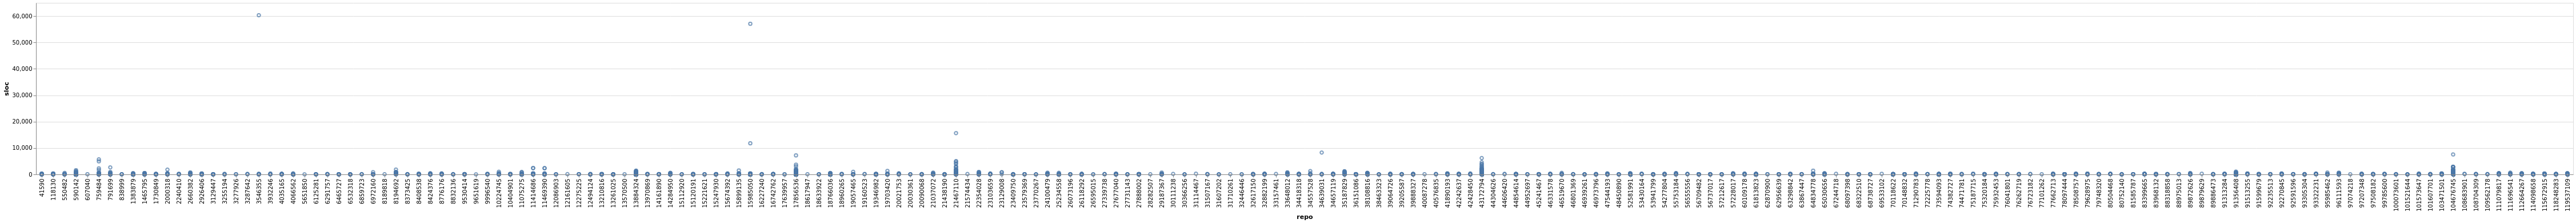

In [29]:
chart = alt.Chart(raw_df_combo).mark_point().encode(
    x = alt.X('repo', type='nominal'),
    y = alt.Y('sloc', title="sloc")
)
chart

In [30]:
chart.save("sloc-vs-repo.png")

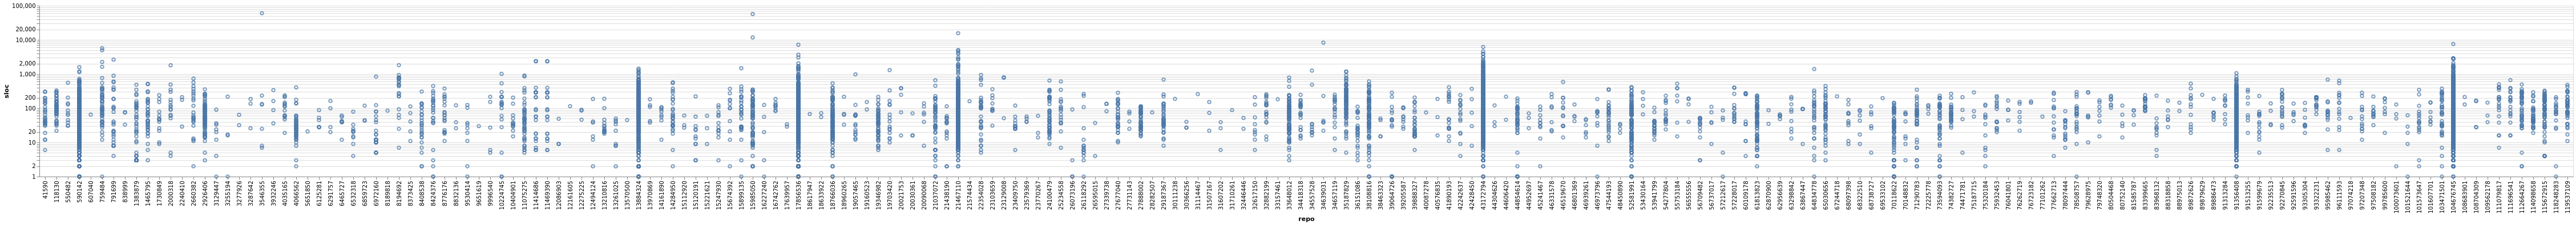

In [31]:
chart = alt.Chart(raw_df_combo).mark_point().encode(
    x = alt.X('repo', type='nominal'),
    y = alt.Y('sloc', scale=alt.Scale(type="log"), title="sloc")
).transform_filter(
    (datum.sloc > 0)
)
chart

In [32]:
chart.save("sloc-vs-repo-logscale.png")

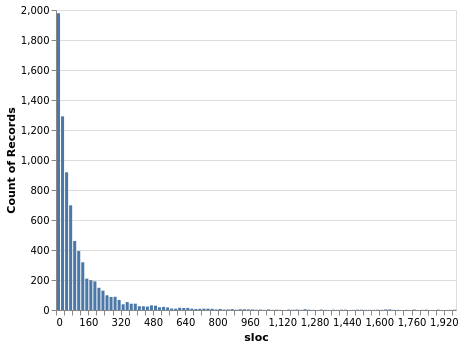

In [33]:
chart = alt.Chart(raw_df_combo).mark_bar().encode(
    x = alt.X('sloc:Q', title="sloc", bin={'maxbins': 100}),
    y = 'count()'
).transform_filter(
    (datum.sloc < 2000) # set cut-off here to make it easier to see distribution
)
chart

In [34]:
chart.save("dist-sloc.png")

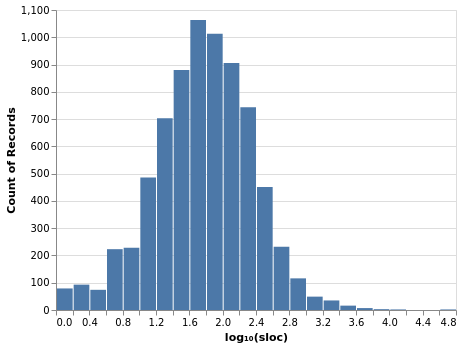

In [35]:
chart = alt.Chart(raw_df_combo).mark_bar().encode(
    x = alt.X('x:Q', title="log₁₀(sloc)", bin={'maxbins': 30}),
    y = 'count()'
).transform_filter(
    (datum.sloc > 0)
).transform_calculate(
    x = 'log(datum.sloc)/LN10' # convert JS logₑ to log₁₀
)
chart

In [36]:
chart.save("dist-sloc-logscale.png")

In [37]:
raw_df_combo.sloc.describe()

count     7907.000000
mean       148.444290
std       1009.654329
min          0.000000
25%         19.000000
50%         54.000000
75%        130.000000
max      60312.000000
Name: sloc, dtype: float64

SLOC appear to be log-normally distrubted

## Remove Files with Parse Errors from Analysis

In [38]:
lint_df_combo.parse_error.value_counts()

False    686072
True        103
Name: parse_error, dtype: int64

In [39]:
print(sorted(filter(lambda x: not pd.isnull(x), lint_df_combo["message-id"].unique())))

['C0102', 'C0103', 'C0111', 'C0112', 'C0113', 'C0114', 'C0115', 'C0116', 'C0121', 'C0122', 'C0123', 'C0200', 'C0201', 'C0202', 'C0203', 'C0204', 'C0205', 'C0301', 'C0302', 'C0303', 'C0304', 'C0305', 'C0321', 'C0325', 'C0326', 'C0330', 'C0410', 'C0411', 'C0412', 'C0413', 'C0414', 'C0415', 'C1001', 'C1801', 'E0001', 'E0012', 'E0101', 'E0102', 'E0107', 'E0110', 'E0202', 'E0203', 'E0211', 'E0213', 'E0237', 'E0301', 'E0302', 'E0401', 'E0402', 'E0601', 'E0602', 'E0603', 'E0604', 'E0611', 'E0632', 'E0633', 'E0701', 'E0702', 'E0704', 'E0711', 'E0712', 'E1002', 'E1003', 'E1004', 'E1101', 'E1102', 'E1111', 'E1120', 'E1121', 'E1123', 'E1124', 'E1126', 'E1127', 'E1128', 'E1130', 'E1133', 'E1135', 'E1136', 'E1137', 'E1139', 'E1200', 'E1205', 'E1300', 'E1305', 'E1306', 'E1307', 'F0001', 'R0123', 'R0124', 'R0201', 'R0202', 'R0203', 'R0205', 'R0901', 'R0902', 'R0903', 'R0904', 'R0911', 'R0912', 'R0913', 'R0914', 'R0915', 'R0916', 'R1701', 'R1702', 'R1703', 'R1704', 'R1705', 'R1706', 'R1707', 'R1708', 

In [40]:
lint_df_combo[lint_df_combo["parse_error"]].repo.value_counts()

76262719    85
4035165      2
46939261     1
20030361     1
30111238     1
74382727     1
34418318     1
41890193     1
32882199     1
17856536     1
71290783     1
41590        1
97508182     1
3932246      1
79748320     1
73594093     1
118130       1
99785600     1
Name: repo, dtype: int64

The "parse_error" column represents syntax errors (E0001). In some cases, the error can be triggered due to syntax errors in imported modules rather than the file itself.
We will remove these files from the analysis, as because if there is a syntax error, Pylint is usually unable to analyse the file any further. (If the syntax error is in an imported module, Pylint can continue, but will not be able to check usage of that module in the same depth).

In [41]:
lint_df_combo[lint_df_combo["internal_error"]].repo.value_counts()

590142       99
43172794     40
104676745    34
13884324     14
2926406      13
115672915     9
15985050      9
8776176       6
17856536      6
759484        5
11075275      5
8408538       4
1465795       4
56737017      3
83968132      3
34657119      3
73594093      3
32617150      3
44854614      3
6972160       3
34418318      2
4066562       2
55753184      2
64834778      2
26118292      2
23409750      2
56709482      2
9530414       2
550482        2
41590         1
42428450      1
4035165       1
15674392      1
32882199      1
19346982      1
39064726      1
54277804      1
101573647     1
79628975      1
15899135      1
18633922      1
20090068      1
6532318       1
9996540       1
20021753      1
63298842      1
95985462      1
68097398      1
75320184      1
74382727      1
2240410       1
13970869      1
2000318       1
39888327      1
16742762      1
65030656      1
Name: repo, dtype: int64

In [42]:
lint_df_combo[lint_df_combo["internal_error"]]

repo                                          path type module  \
1567    56709482          56709482/hotel_sentiment/__init__.py  NaN    NaN   
1603    56709482  56709482/hotel_sentiment/spiders/__init__.py  NaN    NaN   
2161     8408538                 8408538/east/asts/__init__.py  NaN    NaN   
2168     8408538             8408538/east/synonyms/__init__.py  NaN    NaN   
2212     8408538                  8408538/analysis/__init__.py  NaN    NaN   
...          ...                                           ...  ...    ...   
668424  74382727                  74382727/crawler/__init__.py  NaN    NaN   
674187  32617150                        32617150/tests/test.py  NaN    NaN   
674188  32617150            32617150/simplebayes/categories.py  NaN    NaN   
674189  32617150              32617150/simplebayes/category.py  NaN    NaN   
674482  13970869                   13970869/corpus/__init__.py  NaN    NaN   

        obj  line  column path.1 symbol message message-id  parse_error  \
1567    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
1603    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2161    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2168    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2212    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
...     ...   ...     ...    ...    ...     ...        ...          ...   
668424  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
674187  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
674188  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
674189  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
674482  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   

        internal_error  
1567              True  
1603              True  
2161              True  
2168              True  
2212              True  
...                ...  
668424            True  
674187            True  
674188            True  
674189            True  
674482            True  

[314 rows x 13 columns]

In [43]:
lint_df_combo[lint_df_combo["internal_error"]].repo.isin(py2_repos).all()

True

The "internal error" column represents cases where the Pylint output was not valid JSON. Upon closer examination, it appears that if there are no errors (either because the file is empty, or because it perfectly follows conventions), then Pylint for Python2 returns no output ("") rather than an empty array ("[]"). This causes the analysis code to flag an internal error when parsing the Pylint output.

**TODO:** Update Pylint code to work-around Pylint Python2 bug rather than treating as an internal error. (fixed 2020-01-28)

We remove any cases of parse errors or internal errors:

In [44]:
lint_df_combo_clean = lint_df_combo[~lint_df_combo["parse_error"] & ~lint_df_combo["internal_error"]]

In [45]:
lint_df_combo_clean[pd.isnull(lint_df_combo_clean["module"])]

repo                                               path type  \
97156   18766036              18766036/iepy/webui/webui/__init__.py  NaN   
97160   18766036              18766036/iepy/webui/webui/settings.py  NaN   
97283   18766036             18766036/iepy/webui/corpus/__init__.py  NaN   
97387   18766036  18766036/iepy/webui/corpus/templatetags/__init...  NaN   
97512   18766036  18766036/iepy/webui/corpus/migrations/__init__.py  NaN   
...          ...                                                ...  ...   
550365  61813823                61813823/pythainlp/util/__init__.py  NaN   
550413  61813823                61813823/pythainlp/util/keyboard.py  NaN   
550456  61813823                61813823/pythainlp/tag/locations.py  NaN   
550510  61813823               61813823/pythainlp/tools/__init__.py  NaN   
587862  62956639                        62956639/models/__init__.py  NaN   

       module  obj  line  column path.1 symbol message message-id  \
97156     NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
97160     NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
97283     NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
97387     NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
97512     NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
...       ...  ...   ...     ...    ...    ...     ...        ...   
550365    NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
550413    NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
550456    NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
550510    NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   
587862    NaN  NaN   NaN     NaN    NaN    NaN     NaN        NaN   

        parse_error  internal_error  
97156         False           False  
97160         False           False  
97283         False           False  
97387         False           False  
97512         False           False  
...             ...             ...  
550365        False           False  
550413        False           False  
550456        False           False  
550510        False           False  
587862        False           False  

[212 rows x 13 columns]

The above rows represent cases where there were no Pylint errrors. This can be because either the file is empty (e.g. an empty __init__.py), or because the file had no issues (e.g. `61813823/pythainlp/util/keyboard.py` -- note `61813823/.circleci/config.yml` shows that this repo did a flake8 lint test as part of the CI process). These files were left in the analysis.

## Merge results into combined Data Frame

In [46]:
lint_df_modules = lint_df_combo_clean[['repo', 'path', 'symbol', 'message-id']].pivot_table(index=['repo', 'path'], columns='symbol', aggfunc='count')
# Flatten columns, and add prefix 'lint_'
lint_df_modules.columns = ["lint_" + c for c in lint_df_modules.columns.get_level_values(1)]
lint_df_modules

lint_abstract-class-instantiated  \
repo      path                                                                     
41590     41590/nlp/counter.py                                               NaN   
          41590/nlp/countermap.py                                            NaN   
          41590/nlp/crp.py                                                   NaN   
          41590/nlp/cythonsetup.py                                           NaN   
          41590/nlp/distributions.py                                         NaN   
...                                                                          ...   
119537109 119537109/utils/oracle/OracleGru.py                                NaN   
          119537109/utils/oracle/OracleLstm.py                               NaN   
          119537109/utils/oracle/OracleSru.py                                NaN   
          119537109/utils/text_process.py                                    NaN   
          119537109/utils/utils.py                                           NaN   

                                                lint_abstract-method  \
repo      path                                                         
41590     41590/nlp/counter.py                                   NaN   
          41590/nlp/countermap.py                                NaN   
          41590/nlp/crp.py                                       NaN   
          41590/nlp/cythonsetup.py                               NaN   
          41590/nlp/distributions.py                             NaN   
...                                                              ...   
119537109 119537109/utils/oracle/OracleGru.py                    NaN   
          119537109/utils/oracle/OracleLstm.py                   NaN   
          119537109/utils/oracle/OracleSru.py                    NaN   
          119537109/utils/text_process.py                        NaN   
          119537109/utils/utils.py                               NaN   

                                                lint_access-member-before-definition  \
repo      path                                                                         
41590     41590/nlp/counter.py                                                   NaN   
          41590/nlp/countermap.py                                                NaN   
          41590/nlp/crp.py                                                       NaN   
          41590/nlp/cythonsetup.py                                               NaN   
          41590/nlp/distributions.py                                             NaN   
...                                                                              ...   
119537109 119537109/utils/oracle/OracleGru.py                                    NaN   
          119537109/utils/oracle/OracleLstm.py                                   NaN   
          119537109/utils/oracle/OracleSru.py                                    NaN   
          119537109/utils/text_process.py                                        NaN   
          119537109/utils/utils.py                                               NaN   

                                                lint_anomalous-backslash-in-string  \
repo      path                                                                       
41590     41590/nlp/counter.py                                                 NaN   
          41590/nlp/countermap.py                                              NaN   
          41590/nlp/crp.py                                                     NaN   
          41590/nlp/cythonsetup.py                                             NaN   
          41590/nlp/distributions.py                                           NaN   
...                                                                            ...   
119537109 119537109/utils/oracle/OracleGru.py                                  NaN   
          119537109/utils/oracle/OracleLstm.py                                 NaN   
          119

In [47]:
lint_df_modules_merged = lint_df_modules.merge(raw_df_combo, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...  \
0                            NaN                      NaN  ...   
1                            NaN                      NaN  ...   
2                            NaN                      NaN  ...   
3                            NaN                      NaN  ...   
4                            NaN                      NaN  ...   
...                          ...                      ...  ...   
7389                         NaN                      NaN  ...   
7390                         NaN                      NaN  ...   
7391            

In [48]:
lint_df_modules_merged2 = lint_df_modules_merged.merge(proj_labels, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged2

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...    loc   lloc  \
0                            NaN                      NaN  ...  255.0  176.0   
1                            NaN                      NaN  ...  213.0  148.0   
2                            NaN                      NaN  ...   70.0   44.0   
3                            NaN                      NaN  ...    8.0    5.0   
4                            NaN                      NaN  ...  103.0   65.0   
...                          ...                      ...  ...    ...    ...   
7389                         NaN                  

In [49]:
lint_df_modules_merged_simp = lint_df_modules_merged2.merge(proj_labels_pivot, how='left', left_on='repo', right_on='repo')
lint_df_modules_merged_simp

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...   ml0  ml1  \
0                            NaN                      NaN  ...   0.0  0.0   
1                            NaN                      NaN  ...   0.0  0.0   
2                            NaN                      NaN  ...   0.0  0.0   
3                            NaN                      NaN  ...   0.0  0.0   
4                            NaN                      NaN  ...   0.0  0.0   
...                          ...                      ...  ...   ...  ...   
7389                         NaN                      NaN  ...  21.0  8

In [50]:
lint_df_modules_merged_simp.to_csv("lint_df_modules_merged_simp.csv")

Summary: We merged everything into one big dataframe of features for exploration

## Exploration

### Exploration of SLOC per category

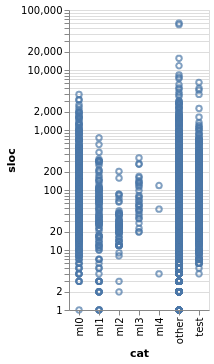

In [51]:
chart = alt.Chart(lint_df_modules_merged_simp).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('sloc', scale=alt.Scale(type="log"), title="sloc"),
).transform_filter(
    (datum.sloc > 0) # can't plot values of 0 on a log scale
)
chart

In [52]:
chart.save("sloc-vs-cat-logscale.png")

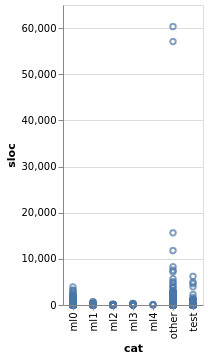

In [53]:
chart2 = alt.Chart(lint_df_modules_merged_simp).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('sloc', title="sloc")
)
chart2

In [54]:
chart.save("sloc-vs-cat.png")

Above plot is misleading: there are more repos in other category, causing it to look greater

In [55]:
lint_df_modules_merged_simp.groupby("cat").describe()["sloc"]

count        mean          std   min    25%   50%     75%      max
cat                                                                       
ml0    1157.0  173.927398   309.794133   1.0  45.00  89.0  186.00   3909.0
ml1     118.0   80.711864   114.500558   1.0  13.25  38.5   96.50    743.0
ml2      73.0   31.506849    31.026925   2.0  14.00  24.0   34.00    204.0
ml3      32.0   94.875000    78.372868  20.0  43.75  65.5  128.25    342.0
ml4       3.0   57.000000    58.025856   4.0  26.00  48.0   83.50    119.0
other  5223.0  158.205629  1222.626283   0.0  21.00  53.0  129.00  60312.0
test    759.0  163.798419   402.121643   4.0  35.00  76.0  162.00   6201.0

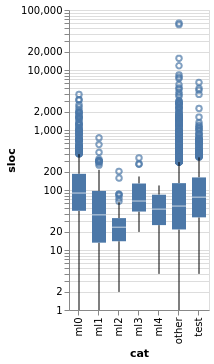

In [56]:
# Note: this cell may cause Chrome to crash (use Firefox instead)

chart4 = alt.Chart(lint_df_modules_merged_simp).mark_boxplot().encode(
    x = 'cat:O',
    y = alt.Y('sloc:Q', scale=alt.Scale(type="log"), title="sloc")
).transform_filter(
    (datum.sloc > 0)
)
chart4

In [57]:
chart.save("sloc-vs-cat-boxplot.png")

### Exploration of differences in Pylint warnings for each category (module basis)

In [58]:
lint_df_modules_merged_simp_mean = lint_df_modules_merged_simp.groupby("cat").mean()

In [59]:
lint_df_modules_merged_simp_mean

repo  lint_abstract-class-instantiated  lint_abstract-method  \
cat                                                                           
ml0    7.055987e+07                               NaN              4.752577   
ml1    6.314698e+07                               NaN                   NaN   
ml2    3.359648e+07                               NaN                   NaN   
ml3    2.439931e+07                               NaN                   NaN   
ml4    2.146711e+07                               NaN                   NaN   
other  4.224384e+07                               3.0              3.053191   
test   3.912837e+07                               1.0              2.809524   

       lint_access-member-before-definition  \
cat                                           
ml0                                1.333333   
ml1                                     NaN   
ml2                                     NaN   
ml3                                     NaN   
ml4                                     NaN   
other                              2.222222   
test                                    NaN   

       lint_anomalous-backslash-in-string  \
cat                                         
ml0                              4.240000   
ml1                              1.750000   
ml2                                   NaN   
ml3                              1.000000   
ml4                                   NaN   
other                            5.880342   
test                             5.000000   

       lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
cat                                                                     
ml0                                        NaN               5.409836   
ml1                                        NaN               1.100000   
ml2                                        NaN                    NaN   
ml3                                        NaN                    NaN   
ml4                                        NaN                    NaN   
other                                 7.500000               2.283388   
test                                 28.571429               3.689655   

       lint_assign-to-new-keyword  lint_assigning-non-slot  \
cat                                                          
ml0                           NaN                      NaN   
ml1                           NaN                      NaN   
ml2                           NaN                      NaN   
ml3                           NaN                      NaN   
ml4                           NaN                      NaN   
other                    3.333333                      4.0   
test                          NaN                      5.0   

       lint_assignment-from-no-return  ...         ml0       ml1        ml2  \
cat                                    ...                                    
ml0                          5.407407  ...  173.812446  5.051858   0.809853   
ml1                               NaN  ...   46.372881  7.449153   5.033898   
ml2                               NaN  ...   12.780822  8.164384  45.027397   
ml3                               NaN  ...    8.562500  8.718750  53.531250   
ml4                               NaN  ...    8.000000  9.000000  57.000000   
other                        1.000000  ...   25.428871  1.761379   3.581032   
test                         4.333333  ...   83.531579  4.630263  10.977632   

             ml3       ml4       other        test       total   frac_ml  \
cat                                                                        
ml0     0.236819  0.020743  141.765774   54.783060  376.480553  0.471592   
ml1     2.364407  0.228814   89.677966   27.855932  178.983051  0.238657   
ml2    23.465753  2.342466  294.561644  114.287671  500.630137  0.059678   
ml3    28.187500  2.812500  346.125000  134.375000  582.312500  0.036028   
ml4    30.000000  3.000000  368.000000  143.000000  618.000000  0.012945   
other   1.84

n.b. ignore "repo" column (average repo id is meaningless)

In [60]:
lint_df_modules_merged_simp_mean.to_csv("lint_df_modules_merged_simp_mean.csv")

In [61]:
lint_df_modules_merged_simp_median = lint_df_modules_merged_simp.groupby("cat").median()

In [62]:
lint_df_modules_merged_simp_median

repo  lint_abstract-class-instantiated  lint_abstract-method  \
cat                                                                       
ml0    78097444                               NaN                   2.0   
ml1    70118622                               NaN                   NaN   
ml2    21467110                               NaN                   NaN   
ml3    21467110                               NaN                   NaN   
ml4    21467110                               NaN                   NaN   
other  21467110                               3.0                   1.0   
test   22354028                               1.0                   1.0   

       lint_access-member-before-definition  \
cat                                           
ml0                                     1.0   
ml1                                     NaN   
ml2                                     NaN   
ml3                                     NaN   
ml4                                     NaN   
other                                   1.0   
test                                    NaN   

       lint_anomalous-backslash-in-string  \
cat                                         
ml0                                   2.0   
ml1                                   1.5   
ml2                                   NaN   
ml3                                   1.0   
ml4                                   NaN   
other                                 2.0   
test                                  3.0   

       lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
cat                                                                     
ml0                                        NaN                    2.0   
ml1                                        NaN                    1.0   
ml2                                        NaN                    NaN   
ml3                                        NaN                    NaN   
ml4                                        NaN                    NaN   
other                                      2.5                    1.0   
test                                      14.0                    2.0   

       lint_assign-to-new-keyword  lint_assigning-non-slot  \
cat                                                          
ml0                           NaN                      NaN   
ml1                           NaN                      NaN   
ml2                           NaN                      NaN   
ml3                           NaN                      NaN   
ml4                           NaN                      NaN   
other                         2.0                      2.0   
test                          NaN                      5.0   

       lint_assignment-from-no-return  ...    ml0  ml1   ml2   ml3  ml4  \
cat                                    ...                                
ml0                               2.0  ...  282.0  3.0   0.0   0.0  0.0   
ml1                               NaN  ...    8.0  7.0   0.0   0.0  0.0   
ml2                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
ml3                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
ml4                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
other                             1.0  ...    1.0  0.0   0.0   0.0  0.0   
test                              2.0  ...    8.0  3.0   0.0   0.0  0.0   

       other   test  total   frac_ml  is_ml_repo  
cat                                               
ml0    203.0   98.0  644.0  0.523292        True  
ml1     29.0    3.0   50.0  0.151515        True  
ml2    368.0  143.0  618.0  0.012945       False  
ml3    368.0  143.0  618.0  0.012945       False  
ml4    368.0  143.0  618.0  0.012945       False  
other  203.0   22.0  319.0  0.003409       False  
test   203.0   61.0  618.0  0.012945       False  

[7 rows x 216 columns]

In [63]:
lint_df_modules_merged_simp_median.to_csv("lint_df_modules_merged_simp_median.csv")

We "melt" the dataframe into key-value pairs for each Pylint variable to make it easier to plot the distributions without having to write queries that refer to individual Pylint variables (column names in previous dataframe):

In [64]:
melted = pd.melt(lint_df_modules_merged_simp, id_vars=["repo", "path", "cat", "sloc", "frac_ml", "is_ml_repo"])
melted

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1567523  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1567524  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1567525  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1567526  119537109       119537109/utils/text_process.py  other   74.0   
1567527  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1567523  0.291667        True                             total    72  
1567524  0.291667        True                             total    72  
1567525  0.291667        True                             total    72  
1567526  0.291667        True                             total    72  
1567527  0.291667        True                             total    72  

[1567528 rows x 8 columns]

In [65]:
melted_sanitized = melted[melted["sloc"] > 0] # ignore empty files

In [66]:
melted_sanitized

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1567523  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1567524  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1567525  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1567526  119537109       119537109/utils/text_process.py  other   74.0   
1567527  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1567523  0.291667        True                             total    72  
1567524  0.291667        True                             total    72  
1567525  0.291667        True                             total    72  
1567526  0.291667        True                             total    72  
1567527  0.291667        True                             total    72  

[1548024 rows x 8 columns]

In [67]:
melted_sanitized2 = melted_sanitized[melted_sanitized["variable"].str.startswith("lint_")]

In [68]:
melted_sanitized2

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1449219  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1449220  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1449221  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1449222  119537109       119537109/utils/text_process.py  other   74.0   
1449223  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1449219  0.291667        True        lint_wrong-import-position   NaN  
1449220  0.291667        True        lint_wrong-import-position   NaN  
1449221  0.291667        True        lint_wrong-import-position   NaN  
1449222  0.291667        True        lint_wrong-import-position   NaN  
1449223  0.291667        True        lint_wrong-import-position   NaN  

[1431192 rows x 8 columns]

In [69]:
melted_sanitized["value"].map(lambda x: type(x) == float).all()

False

In [70]:
melted_sanitized2["value"].map(lambda x: type(x) == float).all()

True

In [71]:
melted_sanitized2.dtypes

repo            int64
path           object
cat            object
sloc          float64
frac_ml       float64
is_ml_repo       bool
variable       object
value          object
dtype: object

In [72]:
melted_sanitized3 = melted_sanitized2.astype({'value': 'float64'})

In [73]:
melted_sanitized3.dtypes

repo            int64
path           object
cat            object
sloc          float64
frac_ml       float64
is_ml_repo       bool
variable       object
value         float64
dtype: object

In [74]:
melted_sanitized3

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1449219  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1449220  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1449221  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1449222  119537109       119537109/utils/text_process.py  other   74.0   
1449223  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable  value  
0        0.000000       False  lint_abstract-class-instantiated    NaN  
1        0.000000       False  lint_abstract-class-instantiated    NaN  
2        0.000000       False  lint_abstract-class-instantiated    NaN  
3        0.000000       False  lint_abstract-class-instantiated    NaN  
4        0.000000       False  lint_abstract-class-instantiated    NaN  
...           ...         ...                               ...    ...  
1449219  0.291667        True        lint_wrong-import-position    NaN  
1449220  0.291667        True        lint_wrong-import-position    NaN  
1449221  0.291667        True        lint_wrong-import-position    NaN  
1449222  0.291667        True        lint_wrong-import-position    NaN  
1449223  0.291667        True        lint_wrong-import-position    NaN  

[1431192 rows x 8 columns]

To prevent crashing the browser, we filter to just the ML categories:

In [75]:
ml_run_all = melted_sanitized3[melted_sanitized3["cat"].isin(["ml0", "ml1", "ml2", "ml3", "ml4"])]

In [76]:
ml_run_subset_filt = ml_run_all.copy()

In [77]:
ml_run_subset_filt

repo                                  path  cat   sloc  \
27          118130            118130/activelearn/mmms.py  ml0  107.0   
28          118130            118130/activelearn/mmpm.py  ml0  106.0   
29          118130          118130/activelearn/oracle.py  ml0   87.0   
30          118130            118130/activelearn/qbc4.py  ml0   86.0   
31          118130        118130/activelearn/qbc_dist.py  ml0   80.0   
...            ...                                   ...  ...    ...   
1449212  119537109  119537109/utils/metrics/DocEmbSim.py  ml0  134.0   
1449219  119537109   119537109/utils/oracle/OracleGru.py  ml0  147.0   
1449220  119537109  119537109/utils/oracle/OracleLstm.py  ml0  170.0   
1449221  119537109   119537109/utils/oracle/OracleSru.py  ml0  139.0   
1449223  119537109              119537109/utils/utils.py  ml0   34.0   

          frac_ml  is_ml_repo                          variable  value  
27       0.355556        True  lint_abstract-class-instantiated    NaN  
28       0.355556        True  lint_abstract-class-instantiated    NaN  
29       0.355556        True  lint_abstract-class-instantiated    NaN  
30       0.355556        True  lint_abstract-class-instantiated    NaN  
31       0.355556        True  lint_abstract-class-instantiated    NaN  
...           ...         ...                               ...    ...  
1449212  0.291667        True        lint_wrong-import-position    NaN  
1449219  0.291667        True        lint_wrong-import-position    NaN  
1449220  0.291667        True        lint_wrong-import-position    NaN  
1449221  0.291667        True        lint_wrong-import-position    NaN  
1449223  0.291667        True        lint_wrong-import-position    NaN  

[271068 rows x 8 columns]

In [78]:
ml_run_subset_filt["normval"] = ml_run_subset_filt["value"]/ml_run_subset_filt["sloc"]

In [79]:
ml_run_subset_filt["normval"].describe()

count    13092.000000
mean         0.047987
std          0.114035
min          0.000256
25%          0.006211
50%          0.016129
75%          0.044371
max          4.500000
Name: normval, dtype: float64

In [80]:
ml_run_subset_filt["normval"][ml_run_subset_filt["normval"] > 0].describe()

count    13092.000000
mean         0.047987
std          0.114035
min          0.000256
25%          0.006211
50%          0.016129
75%          0.044371
max          4.500000
Name: normval, dtype: float64

For the purpose of plotting data on a log-scale, we replace any values of with a small number (0.00015).

In [81]:
x = ml_run_subset_filt["normval"]
ml_run_subset_filt["normval"] = x.where(x > 0.00015, other=0.00015)

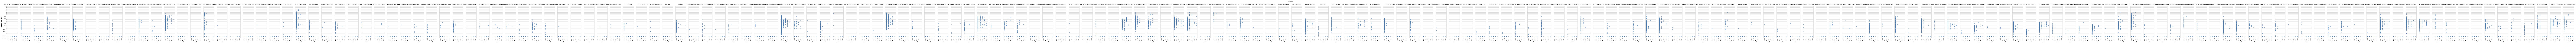

In [82]:
chart = alt.Chart(ml_run_subset_filt).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    #y = alt.Y('normval', log ),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
)
chart

In [83]:
chart.save("sloc-vs-cat-trellis.png")

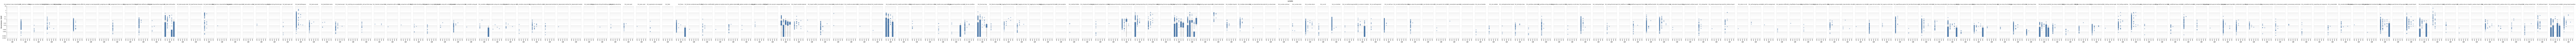

In [84]:
chart = alt.Chart(ml_run_subset_filt).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    #y = alt.Y('normval', log ),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
)
chart

In [85]:
chart.save("sloc-vs-cat-trellis-boxplot.png")

### Exploration of differences in Pylint warnings for each category (repo/category basis)

This section groups the data by repo and category prior to visualisation (e.g. repo 21467110 ML0, repo 21467110 ML1, ..., repo 21467110 other).

In theory we could use Altair/Vega-lite to aggregate/group the data, however, due to the large number of rows it tends to crash the browser.
To avoid this we manually pre-aggregate data using Pandas prior to visualising it.

In [86]:
melted_sanitized3_grouped = melted_sanitized3.groupby(["repo", "cat", "variable"]).mean()
melted_sanitized3_grouped["normval"] = melted_sanitized3_grouped["value"] / melted_sanitized3_grouped["sloc"]

In [87]:
melted_sanitized3_grouped

sloc   frac_ml  \
repo      cat   variable                                                       
41590     other lint_abstract-class-instantiated         85.350000  0.000000   
                lint_abstract-method                     85.350000  0.000000   
                lint_access-member-before-definition     85.350000  0.000000   
                lint_anomalous-backslash-in-string       85.350000  0.000000   
                lint_anomalous-unicode-escape-in-string  85.350000  0.000000   
...                                                            ...       ...   
119537109 other lint_useless-super-delegation            58.363636  0.291667   
                lint_using-constant-test                 58.363636  0.291667   
                lint_wildcard-import                     58.363636  0.291667   
                lint_wrong-import-order                  58.363636  0.291667   
                lint_wrong-import-position               58.363636  0.291667   

                                                         is_ml_repo  value  \
repo      cat   variable                                                     
41590     other lint_abstract-class-instantiated              False    NaN   
                lint_abstract-method                          False    NaN   
                lint_access-member-before-definition          False    NaN   
                lint_anomalous-backslash-in-string            False    5.0   
                lint_anomalous-unicode-escape-in-string       False    NaN   
...                                                             ...    ...   
119537109 other lint_useless-super-delegation                  True    NaN   
                lint_using-constant-test                       True    NaN   
                lint_wildcard-import                           True    1.0   
                lint_wrong-import-order                        True    1.5   
                lint_wrong-import-position                     True    NaN   

                                                          normval  
repo      cat   variable                                           
41590     other lint_abstract-class-instantiated              NaN  
                lint_abstract-method                          NaN  
                lint_access-member-before-definition          NaN  
                lint_anomalous-backslash-in-string       0.058582  
                lint_anomalous-unicode-escape-in-string       NaN  
...                                                           ...  
119537109 other lint_useless-super-delegation                 NaN  
                lint_using-constant-test                      NaN  
                lint_wildcard-import                     0.017134  
                lint_wrong-import-order                  0.025701  
                lint_wrong-import-position                    NaN  

[81536 rows x 5 columns]

In [88]:
melted_sanitized3_grouped["normval"].describe()

count    9636.000000
mean        0.049902
std         0.217636
min         0.000115
25%         0.009530
50%         0.017675
75%         0.040001
max        16.087034
Name: normval, dtype: float64

In [89]:
melted_sanitized3_grouped[melted_sanitized3_grouped["sloc"] == 0]

Empty DataFrame
Columns: [sloc, frac_ml, is_ml_repo, value, normval]
Index: []

In [90]:
melted_sanitized3_grouped_flat = pd.DataFrame(melted_sanitized3_grouped.to_records())

In [91]:
melted_sanitized3_grouped_flat

repo    cat                                 variable       sloc  \
0          41590  other         lint_abstract-class-instantiated  85.350000   
1          41590  other                     lint_abstract-method  85.350000   
2          41590  other     lint_access-member-before-definition  85.350000   
3          41590  other       lint_anomalous-backslash-in-string  85.350000   
4          41590  other  lint_anomalous-unicode-escape-in-string  85.350000   
...          ...    ...                                      ...        ...   
81531  119537109  other            lint_useless-super-delegation  58.363636   
81532  119537109  other                 lint_using-constant-test  58.363636   
81533  119537109  other                     lint_wildcard-import  58.363636   
81534  119537109  other                  lint_wrong-import-order  58.363636   
81535  119537109  other               lint_wrong-import-position  58.363636   

        frac_ml  is_ml_repo  value   normval  
0      0.000000       False    NaN       NaN  
1      0.000000       False    NaN       NaN  
2      0.000000       False    NaN       NaN  
3      0.000000       False    5.0  0.058582  
4      0.000000       False    NaN       NaN  
...         ...         ...    ...       ...  
81531  0.291667        True    NaN       NaN  
81532  0.291667        True    NaN       NaN  
81533  0.291667        True    1.0  0.017134  
81534  0.291667        True    1.5  0.025701  
81535  0.291667        True    NaN       NaN  

[81536 rows x 8 columns]

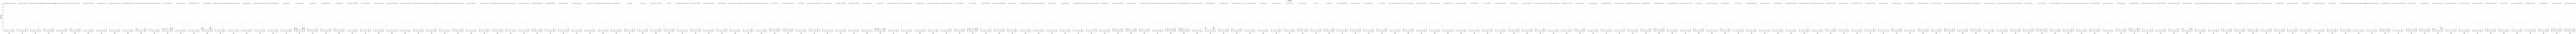

In [92]:
# This plot can crash Chrome browser (use Firefox instead)

chart = alt.Chart(melted_sanitized3_grouped_flat).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval'),
    column = 'variable'
)
chart

In [93]:
chart.save("normval-vs-cat-trellis.png")

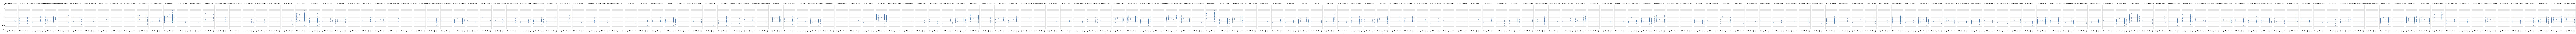

In [94]:
chart = alt.Chart(melted_sanitized3_grouped_flat).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_filter(
    (datum.normval > 0)
)
chart

In [95]:
chart.save("normval-vs-cat-trellis-logscale.png")

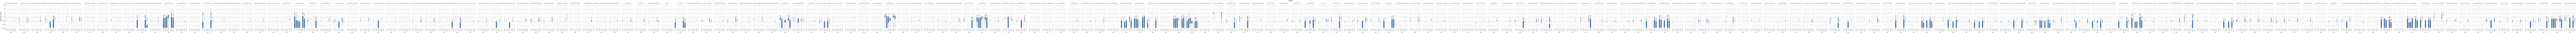

In [96]:
chart = alt.Chart(melted_sanitized3_grouped_flat).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
#.transform_filter(
    #(datum.normval > 0)
#)
chart

In [97]:
chart.save("normval-vs-cat-trellis-logscale-boxplot.png")

### Controlling for Repo Depth

Only some (typically large) repos have ML code with 3 to 4 layers of indirection. This could lead to bias (as the repos in the ML 3 and ML 4 categories are special). This section first filters repos to only those that contain code in each category so that all categories display data across the same sample.

(All selected repos will have a ML0, ML1, and ML2 cat. We also show the other categories -- but some of these may have an uneven number of datapoints, so should be interpreted with more caution)

In [98]:
deep_repos = melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "ml2"].repo.unique()

In [99]:
deep_repos

array([ 21467110,  24100479,  43172794,  46331578,  52581991,  70118622,
        95985462, 103471501, 112664267, 114098658])

In [100]:
melted_sanitized3_grouped_flat_deeponly = melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["repo"].isin(deep_repos)]
melted_sanitized3_grouped_flat_deeponly = melted_sanitized3_grouped_flat_deeponly.fillna(0)

In [101]:
melted_sanitized3_grouped_flat_deeponly

repo    cat                                 variable     sloc  \
24108   21467110    ml0         lint_abstract-class-instantiated  267.375   
24109   21467110    ml0                     lint_abstract-method  267.375   
24110   21467110    ml0     lint_access-member-before-definition  267.375   
24111   21467110    ml0       lint_anomalous-backslash-in-string  267.375   
24112   21467110    ml0  lint_anomalous-unicode-escape-in-string  267.375   
...          ...    ...                                      ...      ...   
79963  114098658  other            lint_useless-super-delegation   95.000   
79964  114098658  other                 lint_using-constant-test   95.000   
79965  114098658  other                     lint_wildcard-import   95.000   
79966  114098658  other                  lint_wrong-import-order   95.000   
79967  114098658  other               lint_wrong-import-position   95.000   

        frac_ml  is_ml_repo  value   normval  
24108  0.012945       False    0.0  0.000000  
24109  0.012945       False    0.0  0.000000  
24110  0.012945       False    0.0  0.000000  
24111  0.012945       False    1.0  0.003740  
24112  0.012945       False    0.0  0.000000  
...         ...         ...    ...       ...  
79963  0.619048        True    0.0  0.000000  
79964  0.619048        True    1.0  0.010526  
79965  0.619048        True    0.0  0.000000  
79966  0.619048        True    5.0  0.052632  
79967  0.619048        True    0.0  0.000000  

[9800 rows x 8 columns]

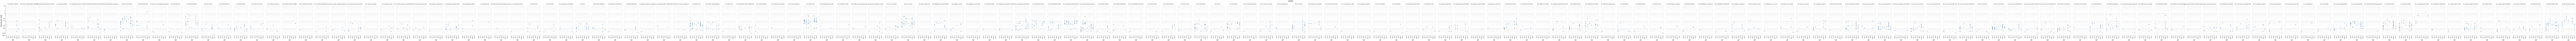

In [102]:
chart = alt.Chart(melted_sanitized3_grouped_flat_deeponly).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_filter(
    (datum.normval > 0)
)
chart

In [103]:
chart.save("normval-vs-cat-trellis-logscale-deeponly.png")

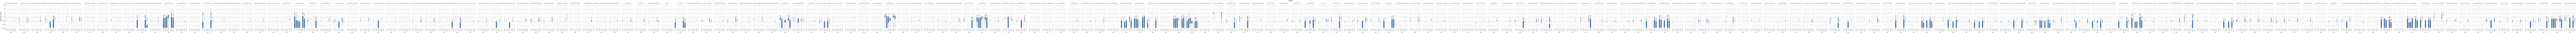

In [104]:
chart = alt.Chart(melted_sanitized3_grouped_flat).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [105]:
chart.save("normval-vs-cat-trellis-logscale-boxplot-deeponly.png")

### Exploration of differences in Pylint warnings for each category (repo basis)

This section groups the data by repo prior to visualisation (e.g. repo 21467110). The entire repo is marked as ML or non-ML (based on the fraction of ML modules in the repo).

In [106]:
melted_sanitized3_grouped_repo = melted_sanitized3.groupby(["repo", "variable"]).mean()
melted_sanitized3_grouped_repo["normval"] = melted_sanitized3_grouped_repo["value"] / melted_sanitized3_grouped_repo["sloc"]
melted_sanitized3_grouped_repo[melted_sanitized3_grouped_repo["sloc"] == 0]
melted_sanitized3_grouped_repoflat = pd.DataFrame(melted_sanitized3_grouped_repo.to_records())

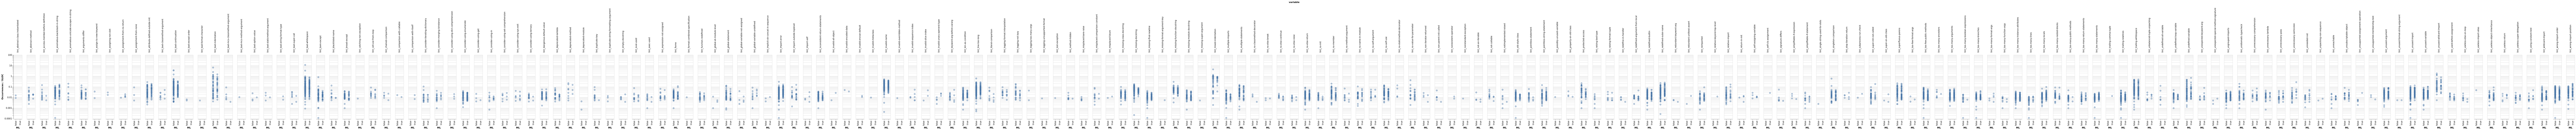

In [107]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).facet(
    column = 'variable:N'
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
)
chart

In [108]:
chart.save("normval-vs-ml-trellis.png")

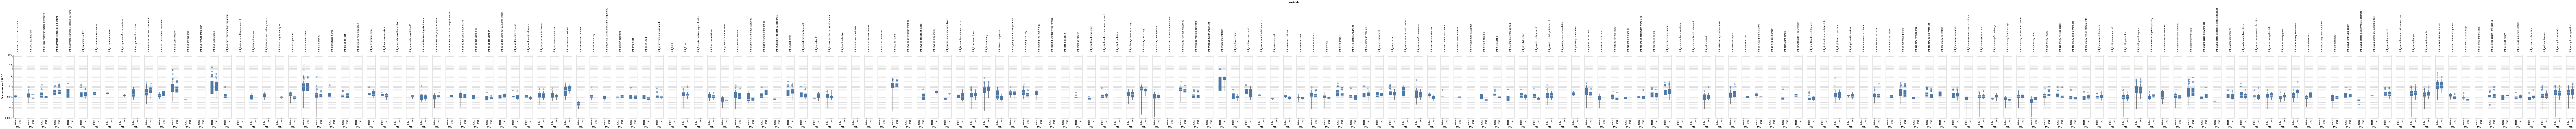

In [109]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_boxplot().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).facet(
    column = 'variable:N'
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
)
chart

In [110]:
chart.save("normval-vs-ml-trellis-boxplot.png")

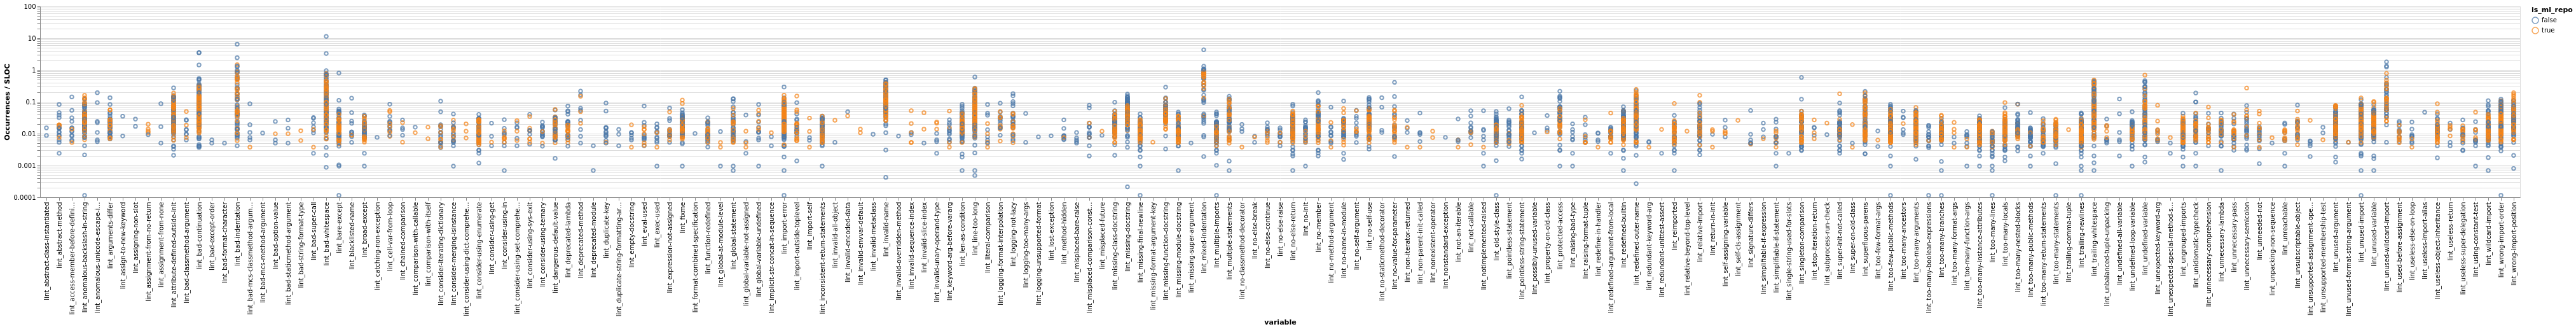

In [111]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = 'variable',
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    color = 'is_ml_repo'
)
chart

In [112]:
chart.save("normval-vs-ml-colour.png")

In [113]:
# following https://vega.github.io/vega-lite/examples/circle_natural_disasters.html
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('variable', type='ordinal'),
    y = alt.Y('value', scale=alt.Scale(type="log"), title="Issues / SLOC"),
    color = alt.Color('repo', type='nominal', legend=alt.Legend(title="repo", orient="bottom")),
    row = 'is_ml_repo'
).transform_filter(
    (datum.normval > 0)
)

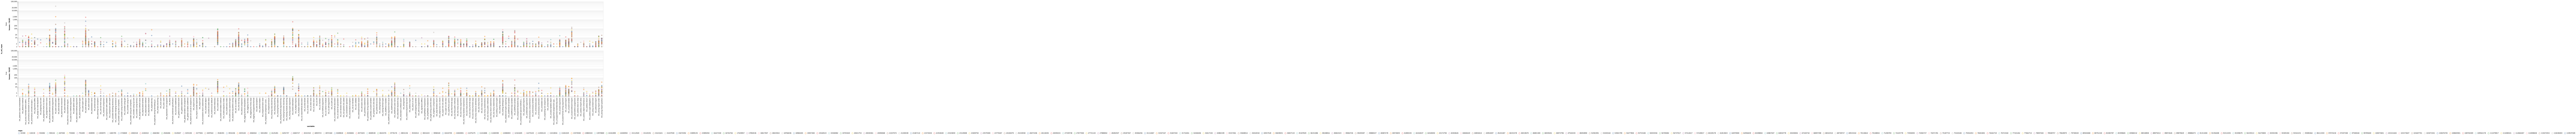

In [114]:
chart

In [115]:
chart.save("normval-vs-ml-repo-colour.png")

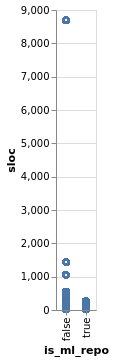

In [116]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    y = alt.Y('sloc', title="sloc"),
    x = 'is_ml_repo'
)
chart

In [117]:
chart.save("sloc-vs-ml.png")

## Which differences between ML repos and non-ML repos are statistically significant?

In [118]:
def one_way_test(a, b, rowname="row"):
    meana = np.mean(a)
    meda = np.median(a)
    stda = np.std(a, ddof=1) # sample SD
    meanb = np.mean(b)
    medb = np.median(b)
    stdb = np.std(b, ddof=1) # sample SD
    # f-test (one-way ANOVA)
    f_stat, f_pval = stats.f_oneway(a, b)
    # kruskal (non-parametric equivalent to the ANOVA testing difference of median)
    try:
        k_stat, k_pval = stats.kruskal(a, b)
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        k_stat, k_pval = (np.nan, np.nan)
    # mannwhitneyu (rank test on independent samples)
    # Disclaimer: "Use only when the number of observation in each sample is > 20"
    try:
        u_stat, u_pval = stats.mannwhitneyu(a, b)
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        u_stat, u_pval = (np.nan, np.nan)
    # TODO: consider Fisher's exact test on errors-vs-non-errors
    
    return [rowname, meana, meda, stda, meanb, medb, stdb, f_stat, f_pval, k_stat, k_pval, u_stat, u_pval]

In [119]:
melted_sanitized3_grouped_repoflat_filled = melted_sanitized3_grouped_repoflat.fillna(0)

In [120]:
melted_sanitized3_grouped_repoflat_filled

repo                                 variable        sloc  \
0          41590         lint_abstract-class-instantiated   92.259259   
1          41590                     lint_abstract-method   92.259259   
2          41590     lint_access-member-before-definition   92.259259   
3          41590       lint_anomalous-backslash-in-string   92.259259   
4          41590  lint_anomalous-unicode-escape-in-string   92.259259   
...          ...                                      ...         ...   
43311  119537109            lint_useless-super-delegation  134.294118   
43312  119537109                 lint_using-constant-test  134.294118   
43313  119537109                     lint_wildcard-import  134.294118   
43314  119537109                  lint_wrong-import-order  134.294118   
43315  119537109               lint_wrong-import-position  134.294118   

        frac_ml  is_ml_repo     value   normval  
0      0.000000       False  0.000000  0.000000  
1      0.000000       False  0.000000  0.000000  
2      0.000000       False  0.000000  0.000000  
3      0.000000       False  5.000000  0.054195  
4      0.000000       False  0.000000  0.000000  
...         ...         ...       ...       ...  
43311  0.291667        True  0.000000  0.000000  
43312  0.291667        True  0.000000  0.000000  
43313  0.291667        True  1.222222  0.009101  
43314  0.291667        True  1.200000  0.008936  
43315  0.291667        True  0.000000  0.000000  

[43316 rows x 7 columns]

In [121]:
rows = []
for factor, factor_data in melted_sanitized3_grouped_repoflat_filled.groupby("variable"):
    a = factor_data["normval"][(factor_data["is_ml_repo"] == True)]
    b = factor_data["normval"][(factor_data["is_ml_repo"] == False)]
    row = one_way_test(a, b, rowname=factor)
    rows.append(row)

/home/andrew/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


WARN: Row lint_fatal: All numbers are identical in kruskal
WARN: Row lint_fatal: All numbers are identical in mannwhitneyu


Comparison of factors (lint errrors), after normalizing for SLOC

In [122]:
df = pd.DataFrame.from_records(rows, columns=["factor", "meana", "meda", "stda", "meanb", "medb", "stdb", "f_stat", "f_pval", "k_stat", "k_pval", "u_stat", "u_pval"])

In [123]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [124]:
df.sort_values("k_pval")

factor     meana      meda      stda  \
155                       lint_too-many-locals  0.015399  0.013953  0.013074   
148                    lint_too-many-arguments  0.014986  0.012697  0.013494   
86                      lint_missing-docstring  0.020587  0.000000  0.023708   
59                           lint_import-error  0.043003  0.038719  0.029415   
157               lint_too-many-public-methods  0.000183  0.000000  0.001268   
89             lint_missing-function-docstring  0.022449  0.013605  0.027669   
34               lint_consider-using-enumerate  0.006750  0.000000  0.008607   
90               lint_missing-module-docstring  0.006930  0.000000  0.009499   
159                   lint_too-many-statements  0.006282  0.006055  0.007383   
153          lint_too-many-instance-attributes  0.008496  0.007884  0.007802   
142                 lint_super-init-not-called  0.003554  0.000000  0.020281   
115                       lint_old-style-class  0.002591  0.000000  0.005456   
171             lint_unnecessary-comprehension  0.002955  0.000000  0.009148   
74                          lint_line-too-long  0.062199  0.052356  0.052108   
149          lint_too-many-boolean-expressions  0.000074  0.000000  0.000669   
93                       lint_multiple-imports  0.002152  0.000000  0.004824   
183                         lint_unused-import  0.026899  0.020513  0.024696   
129                            lint_reimported  0.004528  0.000000  0.011332   
189            lint_useless-object-inheritance  0.004630  0.000000  0.012076   
85                lint_missing-class-docstring  0.007633  0.000000  0.011816   
33      lint_consider-using-dict-comprehension  0.000487  0.000000  0.002704   
116                   lint_pointless-statement  0.000262  0.000000  0.001412   
44                          lint_duplicate-key  0.000067  0.000000  0.000599   
169                     lint_ungrouped-imports  0.006284  0.000000  0.008638   
121                      lint_raising-bad-type  0.000000  0.000000  0.000000   
184                       lint_unused-variable  0.019164  0.015823  0.018939   
156                lint_too-many-nested-blocks  0.002286  0.000000  0.009900   
100                               lint_no-init  0.000396  0.000000  0.001833   
8               lint_assignment-from-no-return  0.000694  0.000000  0.003158   
4      lint_anomalous-unicode-escape-in-string  0.000000  0.000000  0.000000   
60                lint_import-outside-toplevel  0.005141  0.000000  0.018995   
107                lint_no-value-for-parameter  0.003972  0.000000  0.010468   
39                 lint_consider-using-ternary  0.000205  0.000000  0.001399   
69                 lint_invalid-sequence-index  0.001169  0.000000  0.006385   
83          lint_misplaced-comparison-constant  0.000357  0.000000  0.002511   
62         lint_inconsistent-return-statements  0.003276  0.000000  0.006521   
164                lint_undefined-all-variable  0.000000  0.000000  0.000000   
30                 lint_comparison-with-itself  0.000284  0.000000  0.001934   
110                  lint_nonexistent-operator  0.000240  0.000000  0.001560   
20                 lint_bad-string-format-type  0.000227  0.000000  0.001516   
65                 lint_invalid-envvar-default  0.000303  0.000000  0.001933   
2         lint_access-member-before-definition  0.000235  0.000000  0.001634   
82                   lint_misplaced-bare-raise  0.000000  0.000000  0.000000   
117            lint_pointless-string-statement  0.006987  0.000000  0.012966   
172                    lint_unnecessary-lambda  0.001396  0.000000  0.005108   
167                lint_unexpected-keyword-arg  0.001859  0.000000  0.009290   
81                          lint_method-hidden  0.000093  0.000000  0.000836   
154                        lint_too-many-lines  0.000650  0.000000  0.002296   
132                        lint_return-in-init  0.000359  0.000000  0.002014   
151                  lint_too-many-forma

In [125]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [126]:
df.to_csv("pylint_ml_significance.csv")